# 入力文字列の処理

--- text2corpus
--- create_co_matrix
--- co2ppmi
--- svd
['the', 'fly', 'it', 'watching', 'them—and', 'cool', 'assistance', 'delighted', 'needn’t', 'dish']
['and', 'water', 'fly', 'grave', 'costs', 'dish', 'watching', 'mercia', 'relieved', 'intellectual']
['where', 'between', 'needn’t', 'doubling', 'difficult', '501(c)(3)', 'puffed', 'pack', 'true_—’', 'delighted']


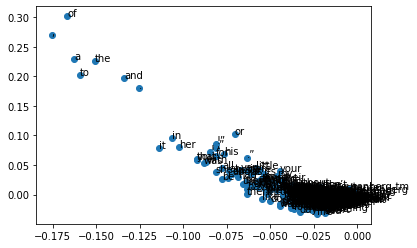

In [64]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

class WordDictionary:
    """
    受け取ったテキストを単語に分解して単語ID（整数）の配列に変換する辞書
    """
    
    def __init__(self):
        self.word2index = {}
        self.index2word = []
        self.word_count = []
        self.latest_id = 0
    
    def text2corpus(self, text):
        result = []
        for word in text.lower().replace('.', ' .').replace(',', ' ,').replace('!', ' !').replace('?', ' ?').split(' '):
            if word not in self.word2index:
                self.word2index[word] = self.latest_id
                self.index2word.append(word)
                self.word_count.append(0)
                self.latest_id += 1
            i = self.word2index[word]
            result.append(i)
            self.word_count[i] += 1
        return np.array(result)

def create_co_matrix(corpus, vocab_size, window_size=1):
    """
    コーパスの共起行列を作成する
    """
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.float32)
    for i in range(corpus_size):
        for j in range(1, window_size+1):
            if i+j < corpus_size:
                co_matrix[corpus[i]][corpus[i+j]] += 1
            if 0 <= i-j:
                co_matrix[corpus[i]][corpus[i-j]] += 1
    return co_matrix

def co2ppmi(co_matrix, eps=1.0e-8):
    """
    PMI (Pointwize Mutual Information, 相互情報量)
    PPMI (Positive PMI)
    """
    cnt_each_word = co_matrix.sum(axis=0)
    cnt_total = cnt_each_word.sum()
    ppmi_matrix = np.zeros_like(co_matrix, dtype=np.float32)
    for i in range(ppmi_matrix.shape[0]):
        for j in range(ppmi_matrix.shape[1]):
            pmi = np.log2((cnt_total * co_matrix[i, j]) / (cnt_each_word[i] * cnt_each_word[j]) + eps)
            ppmi_matrix[i][j] = max(0, pmi)
    return ppmi_matrix

def similar_with(word, U, wd, num_result=10):
    """
    与えられた単語に近い単語を返す
    """
    result = []
    if word not in wd.word2index:
        return result
    u = (U.T / U.sum(axis=1)).T
    i = wd.word2index[word]
    result_ids = np.argsort(u.dot(u[i]))[::-1][:num_result]
    for j in result_ids:
        result.append(wd.index2word[j])
    return result

wd = WordDictionary()

#text = 'This is a pen. I like this pen. This pen is mine.'
text = 'You say goodbye and I say hello.'
#with open('../data/nlp/sample.txt', 'r') as f:
#    text = ' '.join(f.readlines()).replace('\n', '').replace(' +', ' ')
with open('../data/nlp/alice_in_wonderland.txt') as f:
    text = ' '.join(f.readlines()).replace('\n', '').replace(' +', ' ')

print('--- text2corpus')
corpus = wd.text2corpus(text)
print('--- create_co_matrix')
co = create_co_matrix(corpus, len(wd.index2word))
print('--- co2ppmi')
ppmi = co2ppmi(co)
print('--- svd')
U, S, V = np.linalg.svd(ppmi)

np.set_printoptions(precision=3)
#print(wd.word2index)
#print(wd.word_count)
#print(co)
#print(ppmi)
#print(U, S, V)

print(similar_with('the', U, wd))
print(similar_with('and', U, wd))
print(similar_with('where', U, wd))

ids = np.array(wd.word_count) >= 10
plt.scatter(U[ids, 0], U[ids, 1])
for i in range(ppmi.shape[0]):
    if ids[i]:
        plt.annotate(wd.index2word[i], (U[i, 0], U[i, 1]))
plt.show()

### 1. 前提：特異値分解定理

$$m \times n$$ 行列

$$
A = \begin{pmatrix}
    a_{11} & \cdots & a_{1n}\\
    \vdots &  & \vdots \\
    a_{m1} & \cdots & a_{mn}\\
\end{pmatrix}
$$

に対して、$$m, n$$ 次の直行行列

$$
\begin{eqnarray}
    U = \begin{pmatrix}
        u_{11} & \cdots & u_{1m}\\
        \vdots &  & \vdots \\
        u_{m1} & \cdots & u_{mm}\\
    \end{pmatrix}
    = \left( \boldsymbol{u}_1, \cdots, \boldsymbol{u}_m \right)
    \\
    V = \begin{pmatrix}
        v_{11} & \cdots & v_{1n}\\
        \vdots & & \vdots \\
        v_{n1} & \cdots & v_{nn}\\
    \end{pmatrix}
    = \left( \boldsymbol{v}_1, \cdots, \boldsymbol{v}_m \right)
\end{eqnarray}
$$

と $$m \times n$$ 行列

$$
S = \begin{cases}
    \begin{pmatrix}
        s_1 &  & 0 \\
        & \ddots & \\
        0 &  & s_n \\
        0 & \cdots & 0 \\
        \vdots & & \vdots \\
        0 & \cdots & 0
    \end{pmatrix}
    & {\rm if} \quad m \gt n
    \\
    \begin{pmatrix}
        s_1 &  & 0 \\
        & \ddots & \\
        0 &  & s_n
    \end{pmatrix}
    & {\rm if} \quad m = n
    \\
    \begin{pmatrix}
        s_1 &  & 0 & 0 & \cdots & 0 \\
        & \ddots & & \vdots & & \vdots \\
        0 &  & s_m & 0 & \cdots & 0
    \end{pmatrix}
    & {\rm if} \quad m \lt n
\end{cases}
$$

$$
s_1 \ge s_2 \ge \cdots \ge s_{m, n}
$$

が存在し、

$$
A = USV^T
$$

### 2. 特異値分解の実行

次元削減対象の $$n$$ 次元の行ベクトル $$m$$ 個を縦に並べた行列を前節の $$A$$ に当てはめる。

（以下、ToDo）

### 3. 次元の削減

$$t$$ 次元まで削減したい場合、
- $$U'$$: $$U$$ の $$t$$ 列目までの要素を抜き出した $$m \times t$$ 行列
- $$S'$$: $$S$$ の $$t$$ 行目、$$t$$ 列目までの要素を抜き出した $$t \times t$$ 行列
- $$V'$$: $$V$$ の $$t$$ 列目までの要素を抜き出した $$n \times t$$ 行列

を用いて計算した

$$
A' \equiv U' S' V'^T
$$

を $$A$$ の近似として用いれば良い。